### File: Model Optimization

##### Goals and Objectives of this file:

##### 1. Basic Model Training and Word Embedding Testing
##### 2. Data Processing => over/under sampling the classes  =>  word embeddings => Mnnb Hyperparameter Tuning
##### 3. Several Classifiers Testing => Different ML Algorithms tests => (hyper)parameter Tuning
##### 4. Testing => Testing on data never seen before => accuracy => precision => confusion matrix => roc/auc curves => learning curve

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import imblearn
import pickle
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

### 1. Basic Model Training and Vectorizer Testing

In [2]:
df = pd.read_csv("datasets/yelp coffee/raw_yelp_review_data_processed.csv")

#### 1.1 Utility Functions

In [3]:
def create_data_split(X,y,vectorizer=False,test_size = 0.2):
    x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=test_size,stratify=y,random_state = 42)
    if vectorizer:
        vectorizer = vectorizer
        x_train = vectorizer.fit_transform(x_train)
        x_test = vectorizer.transform(x_test)
    return x_train,x_test,y_train,y_test

In [4]:
def remove_stop_words(text):
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

In [5]:
def get_trained_model(classifier,x_train,x_test,y_train,y_test):
    model = classifier
    model.fit(x_train, y_train)
    return model

In [6]:
def get_model_accuracies(model,x_train,x_test,y_train,y_test):
    train_accuracy = model.score(x_train,y_train)
    val_accuracy = model.score(x_test, y_test)
    return ['{:.2f}%'.format(train_accuracy * 100),'{:.2f}%'.format(val_accuracy * 100)]

In [7]:
def print_accuracies(accuracy_scores):
    print("Training Accuracy:" + accuracy_scores[0])
    print("Testing Accuracy:" + accuracy_scores[1])

In [8]:
def adjust_xgb_labels(y_train,y_test):
    y_train_xgb = []
    y_val_xgb = []

    for label in y_train:
        y_train_xgb.append(label - 1)

    for label in y_test:
        y_val_xgb.append(label - 1)
    
    return y_train_xgb,y_val_xgb

In [9]:
def show_classification_report(y_test,y_pred):
    print("Classification Report = \n ",metrics.classification_report(y_test,y_pred))

In [10]:
def show_conf_matrix(model, x_test, y_test):
    plot_confusion_matrix(model, x_test, y_test)  
    plt.title('Confussion Matrix')
    plt.show()

In [11]:
def show_roc_curve(y_pred, y_test):
    auc = roc_auc_score(y_pred, y_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, 'g-',label ='AUC:%.3f'%auc)
    plt.legend(loc=4)
    plt.show()

In [12]:
def show_learning_curve(model, X, y,cv = 5):
    train_sizes_model, train_scores_model, valid_scores_model, *_ =learning_curve(model, X, y,cv=cv,
                    scoring='accuracy',n_jobs=-1)
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(x=train_sizes_model,y= train_scores_model.mean(axis=1), color='b')
    ax.scatter(x=train_sizes_model,y=valid_scores_model.mean(axis=1), color='r')
    ax.plot(train_sizes_model,train_scores_model.mean(axis=1), color='b')
    ax.plot(train_sizes_model,valid_scores_model.mean(axis=1), color='r')
    ax.set_xlabel('Training in blue, Testing in red')
    ax.set_ylabel('Accuracy')
    ax.set_title('Learning Curve')
    plt.show()

In [13]:
def show_metrics(model,x_train,x_test,y_train,y_test,X,y):
    show_conf_matrix(model, x_test, y_test)
    show_roc_curve(y_pred, y_test)
    show_classification_report(y_test,y_pred)
    show_learning_curve(model, X, y)

#### 1.2 Removing Stop Words

In [14]:
df['full_review_text'] = [remove_stop_words(text) for text in df['full_review_text']]

#### 1.3 Train-Test Split + Basic Model

In [15]:
X = df['full_review_text']
y = df['star_rating']

In [16]:
x_train_tfidf,x_test_tfidf,y_train,y_test = create_data_split(X,y,TfidfVectorizer())

##### Decision Tree

In [17]:
model_DT = get_trained_model(DecisionTreeClassifier(),x_train_tfidf,x_test_tfidf,y_train,y_test)
accuracy_scores = get_model_accuracies(model_DT,x_train_tfidf,x_test_tfidf,y_train,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:100.00%
Testing Accuracy:47.65%


##### Multinomial Naive Bayes

In [18]:
model_NB = get_trained_model(MultinomialNB(),x_train_tfidf,x_test_tfidf,y_train,y_test)
accuracy_scores = get_model_accuracies(model_NB,x_train_tfidf,x_test_tfidf,y_train,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:52.73%
Testing Accuracy:50.11%


### This result can be better...

### 2. Data Processing

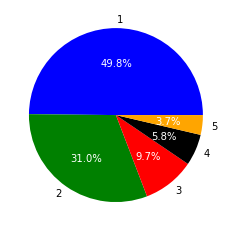

In [19]:
_, _, autotexts = plt.pie(y.value_counts(),colors = ['blue','green','red','black','orange'],labels = [1,2,3,4,5],autopct= '%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')

### This dataset will be balanced using several different techniques.

### 2.1 Data Resampling

#### Random Oversampling

In [20]:
random_oversampler = RandomOverSampler(random_state=42)
ro_x_tfidf,ro_y = random_oversampler.fit_resample(x_train_tfidf, y_train)

In [21]:
ro_y.value_counts()

4    2757
5    2757
3    2757
2    2757
1    2757
Name: star_rating, dtype: int64

##### Decision Tree

In [22]:
model_DT = get_trained_model(DecisionTreeClassifier(),ro_x_tfidf,x_test_tfidf,ro_y,y_test)
accuracy_scores = get_model_accuracies(model_DT,ro_x_tfidf,x_test_tfidf,ro_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:100.00%
Testing Accuracy:45.48%


##### Multinomial Naive Bayes

In [23]:
model_NB = get_trained_model(MultinomialNB(),ro_x_tfidf,x_test_tfidf,ro_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,ro_x_tfidf,x_test_tfidf,ro_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:90.98%
Testing Accuracy:53.51%


#### Random Undersampling

In [24]:
random_underSampler = RandomUnderSampler(random_state=42)
ru_x_tfidf,ru_y = random_underSampler.fit_resample(x_train_tfidf, y_train)

In [25]:
ru_y.value_counts()

1    202
2    202
3    202
4    202
5    202
Name: star_rating, dtype: int64

In [26]:
model_NB = get_trained_model(MultinomialNB(),ru_x_tfidf,x_test_tfidf,ru_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,ru_x_tfidf,x_test_tfidf,ru_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:97.13%
Testing Accuracy:45.84%


#### SMOTE

In [27]:
smote_resample = SMOTE(random_state=42)
smote_x_tfidf,smote_y = smote_resample.fit_resample(x_train_tfidf, y_train)

In [28]:
smote_y.value_counts()

4    2757
5    2757
3    2757
2    2757
1    2757
Name: star_rating, dtype: int64

In [29]:
model_NB = get_trained_model(MultinomialNB(),smote_x_tfidf,x_test_tfidf,smote_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,smote_x_tfidf,x_test_tfidf,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:90.82%
Testing Accuracy:51.05%


### According to the accuracy results: Random Oversampling was the best method for data resampling using these basic parameters, and on TF-IDF.

### 2.2 Word Embeddings

### Word2Vec (BoW)

In [30]:
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(X)
bow_array = bow_matrix.toarray()
bow_df = pd.DataFrame(data=bow_array,columns = bow_vectorizer.vocabulary_.keys())

In [31]:
bow_df.head()

,love,loved,atmosphere,every,corner,coffee,shop,style,swing,ordered,...,deliciousand,rustica,romaine,predictably,roomier,windowed,actuality,crass,budha,digestion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
(bow_df['love'] != 0).sum()

8

### TF-IDF 

In [33]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_matrix = tf_idf_vectorizer.fit_transform(X)
tf_idf_array = bow_matrix.toarray()
tf_idf_df = pd.DataFrame(data=tf_idf_array,columns=bow_vectorizer.vocabulary_.keys())

In [34]:
tf_idf_df.head()

,love,loved,atmosphere,every,corner,coffee,shop,style,swing,ordered,...,deliciousand,rustica,romaine,predictably,roomier,windowed,actuality,crass,budha,digestion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
(tf_idf_df['love'] != 0).sum()

8

### Word2Vec vs TF-IDF (with Random Resampling)

##### Word2Vec

##### Random Oversampler

In [36]:
random_oversampler = RandomOverSampler(random_state=42)

In [37]:
x_train_bow,x_test_bow,y_train,y_test = create_data_split(X,y,vectorizer=bow_vectorizer)

In [38]:
ro_x_bow,ro_y = random_oversampler.fit_resample(x_train_bow, y_train)


model_NB = get_trained_model(MultinomialNB(),ro_x_bow,x_test_bow,ro_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,ro_x_bow,x_test_bow,ro_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:90.69%
Testing Accuracy:56.40%


In [39]:
y_pred = model_NB.predict(x_test_bow)
print("MNNB Classification Report = \n ",metrics.classification_report(y_test,y_pred))

MNNB Classification Report = 
                precision    recall  f1-score   support

           1       0.53      0.45      0.49        51
           2       0.26      0.25      0.25        81
           3       0.29      0.37      0.32       134
           4       0.47      0.50      0.49       428
           5       0.74      0.69      0.71       689

    accuracy                           0.56      1383
   macro avg       0.46      0.45      0.45      1383
weighted avg       0.58      0.56      0.57      1383



##### TF-IDF

In [40]:
x_train_tfidf,x_test_tfidf,y_train,y_test = create_data_split(X,y,vectorizer=TfidfVectorizer())
ro_x_tfidf,ro_y = random_oversampler.fit_resample(x_train_tfidf, y_train)

model_NB = get_trained_model(MultinomialNB(),ro_x_tfidf,x_test_tfidf,ro_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,ro_x_tfidf,x_test_tfidf,ro_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:90.98%
Testing Accuracy:53.51%


### Based on the previous results: Word2Vec Outperformed TF-IDF

### Word2Vec vs TF-IDF (Optimization)

In [41]:
embed_cv = 5

In [42]:
x_train, x_test, y_train, y_test = create_data_split(X, y, test_size=0.2)

In [43]:
w2v_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [44]:
tfidf_pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [45]:
w2v_params = {
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'vect__max_df': [0.5, 0.75, 1.0]
}

In [46]:
tfidf_params = {
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'vect__max_df': [0.5, 0.75, 1.0]
}

In [47]:
count_grid_search = GridSearchCV(w2v_pipeline, param_grid=w2v_params, cv=embed_cv, n_jobs=-1)
count_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__max_df': [0.5, 0.75, 1.0],
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [48]:
tfidf_grid_search = GridSearchCV(tfidf_pipeline, param_grid=tfidf_params, cv=embed_cv, n_jobs=-1)
tfidf_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__max_df': [0.5, 0.75, 1.0],
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [49]:
print("Word2Vec best parameters: ", count_grid_search.best_params_)
print("Word2Vec best score: ", count_grid_search.best_score_)

Word2Vec best parameters:  {'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}
Word2Vec best score:  0.5703238147511072


In [50]:
print("TF-IDF best parameters: ", tfidf_grid_search.best_params_)
print("TF-IDF best score: ", tfidf_grid_search.best_score_)

TF-IDF best parameters:  {'vect__max_df': 0.5, 'vect__ngram_range': (1, 1)}
TF-IDF best score:  0.5007230005995057


### Based on the previous results: Word2Vec once again outperforms TF-IDF

### Overall, for this specific dataset, and model, Word2Vec is a better choice.

In [51]:
bow_vectorizer = CountVectorizer(max_df = 0.75, ngram_range=(1, 1),encoding = 'utf-8',binary=False)
x_train_bow,x_test_bow,y_train,y_test = create_data_split(X,y,vectorizer=bow_vectorizer)

### Now, the next step is to find the best resampling technique for Word2Vec

##### Random Undersampler

In [52]:
random_underSampler = RandomUnderSampler(random_state=42)

In [53]:
ru_x_bow,ru_y = random_underSampler.fit_resample(x_train_bow, y_train)

model_NB = get_trained_model(MultinomialNB(),ru_x_bow,x_test_bow,ru_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,ru_x_bow,x_test_bow,ru_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:93.56%
Testing Accuracy:42.08%


In [54]:
y_pred = model_NB.predict(x_test_bow)
print("MNNB Classification Report = \n ",metrics.classification_report(y_test,y_pred))

MNNB Classification Report = 
                precision    recall  f1-score   support

           1       0.39      0.71      0.50        51
           2       0.19      0.30      0.23        81
           3       0.18      0.43      0.25       134
           4       0.39      0.48      0.43       428
           5       0.81      0.38      0.51       689

    accuracy                           0.42      1383
   macro avg       0.39      0.46      0.39      1383
weighted avg       0.57      0.42      0.45      1383



#### SMOTE

In [55]:
smote_resample = SMOTE(random_state=42)

In [56]:
smote_x_bow,smote_y = smote_resample.fit_resample(x_train_bow, y_train)

model_NB = get_trained_model(MultinomialNB(),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:71.61%
Testing Accuracy:57.92%


In [57]:
y_pred = model_NB.predict(x_test_bow)
print("MNNB Classification Report = \n ",metrics.classification_report(y_test,y_pred))

MNNB Classification Report = 
                precision    recall  f1-score   support

           1       0.68      0.33      0.45        51
           2       0.39      0.19      0.25        81
           3       0.32      0.22      0.26       134
           4       0.46      0.54      0.49       428
           5       0.70      0.74      0.72       689

    accuracy                           0.58      1383
   macro avg       0.51      0.40      0.43      1383
weighted avg       0.57      0.58      0.57      1383



### Based on these results: SMOTE and Random Oversampling were the best resampling techniques specifically for Word2Vec

### When the results are observed closely, we can see that Random Oversampling causes the model to overfit, whereas that was not the case with SMOTE. 




### it is important to take note of something when coming to a conclusion on which technique was better:

#### 1. This dataset is too small to draw a definitive conclusion on which resampling technique is best.

#### 2. The imbalance in the dataset is very severe, which works better in favour of SMOTE, as it is better at replicating synthetic labels for minority classes.

#### 3. Random Oversampling outperformed SMOTE on other metrics such as F1-Score and Precision

#### 4. Both resampling techniques are not optimal for a multi-class classification problem.

### In conclusion, there is not enough data to get a concrete answer on which resampling techinque would perform best. Therefore, SMOTE will be used as it was less likely to overfit, and the results are nearly identical to Random Oversampler, which unfortunately produced less values per class.

### Sources:
https://file.techscience.com/ueditor/files/cmc/TSP_CMC_69-1/TSP_CMC_17827/TSP_CMC_17827.pdf

https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a

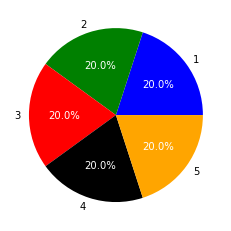

In [58]:
_, _, autotexts = plt.pie(smote_y.value_counts(),colors = ['blue','green','red','black','orange'],labels = [1,2,3,4,5],autopct= '%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')

In [59]:
smote_x_bow

<13785x16515 sparse matrix of type '<class 'numpy.int64'>'
	with 776629 stored elements in Compressed Sparse Row format>

### 2.3 Hyperparameter Tuning on the MNB model.

### First Step: Validation split

### Dataset will be split further from train-test into train-validation-test to better evaluate the model.

#### some definitons:

#### 1. x_train_val = x_bow with smote resampling and validation split

#### 2. x_val = x_test with smote resampling and validation split

#### 3. y_train_val = y_train with smote resampling and validation split

#### 4. y_val = y_test with smote resampling and validation split

In [60]:
x_train_val, x_val, y_train_val, y_val = create_data_split(smote_x_bow, smote_y, test_size=0.25) # 0.25 x 0.8 = 0.2

### Second Step: Hyperparameter Tuning

### 1. Grid Search

In [61]:
param_grid = {"alpha": range(1,10)}
mnnb = MultinomialNB()
grid_search = GridSearchCV(mnnb, param_grid,cv=5, verbose=2)

grid_search.fit(x_train_val, y_train_val)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=3; total time=   0.0s
[CV] END ........................................

In [62]:
print(grid_search.score(x_train_val, y_train_val))
print(grid_search.score(x_val, y_val))

0.6977171599922616
0.5938497243980273


### 2. Randomized hyperparameter optimization

In [63]:
mnnb = MultinomialNB()
random_search = RandomizedSearchCV(mnnb, param_grid, cv=5, verbose=2, n_jobs=-1, n_iter=5)
random_search.fit(x_train_val, y_train_val)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=5, n_jobs=-1,
                   param_distributions={'alpha': range(1, 10)}, verbose=2)

In [64]:
random_search.score(x_val, y_val)

0.5938497243980273

### Based on these results, the alpha value is best kept at default (1.0) as there is beneficial progess that occurs after that point.

### 3. Several Classifiers Testing

### 3.1 Strong Classifiers

##### 1. Random Forest

In [65]:
rf_clf = get_trained_model(RandomForestClassifier(random_state=42),x_train_val,x_val,y_train_val,y_val)
accuracy_scores = get_model_accuracies(rf_clf,x_train_val,x_val,y_train_val,y_val)
print_accuracies(accuracy_scores)

Training Accuracy:95.05%
Testing Accuracy:71.86%


##### 2. SVM

In [66]:
svm_clf = get_trained_model(SVC(kernel='rbf',random_state = 42),x_train_val,x_val,y_train_val,y_val)
accuracy_scores = get_model_accuracies(svm_clf,x_train_val,x_val,y_train_val,y_val)
print_accuracies(accuracy_scores)

Training Accuracy:78.97%
Testing Accuracy:62.11%


##### 3. Ensemble (Bagging) Model (KNN) 

In [67]:
ens_knn_clf = get_trained_model(BaggingClassifier(KNeighborsClassifier(),random_state = 42),x_train_val,x_val,y_train_val,y_val)
accuracy_scores = get_model_accuracies(ens_knn_clf,x_train_val,x_val,y_train_val,y_val)
print_accuracies(accuracy_scores)

Training Accuracy:63.86%
Testing Accuracy:54.57%


##### 4. Ensemble (Bagging) Model (MNNB)

In [68]:
ens_mnnb_clf = get_trained_model(BaggingClassifier(MultinomialNB(),random_state = 42),x_train_val,x_val,y_train_val,y_val)
accuracy_scores = get_model_accuracies(ens_mnnb_clf,x_train_val,x_val,y_train_val,y_val)
print_accuracies(accuracy_scores)

Training Accuracy:67.86%
Testing Accuracy:58.31%


##### 5. Gradient Boosting  (Adaboost) Model (MNNB)

In [69]:
ens_mnnb_clf_ada = get_trained_model(AdaBoostClassifier(MultinomialNB(),random_state = 42),x_train_val,x_val,y_train_val,y_val)
accuracy_scores = get_model_accuracies(ens_mnnb_clf_ada,x_train_val,x_val,y_train_val,y_val)
print_accuracies(accuracy_scores)

Training Accuracy:55.48%
Testing Accuracy:52.80%


##### 6. Gradient Boosting (XGBoost) Model

#### Some Label adjustments specifically for XGBoost

In [70]:
y_train_xgb,y_val_xgb = adjust_xgb_labels(y_train_val,y_val)

#### Model Training

In [71]:
xgb_model = get_trained_model(XGBClassifier(random_state = 42),x_train_val,x_val,y_train_xgb,y_val_xgb)
accuracy_scores = get_model_accuracies(xgb_model,x_train_val,x_val,y_train_xgb,y_val_xgb)
print_accuracies(accuracy_scores)

Training Accuracy:96.32%
Testing Accuracy:85.47%


### Based on these results, These Were the Top 3 Classifiers without Parameter Tuning:

#### 3. SVM

#### 2. Random Forest

#### 1. XGBoost

### 3.2 Parameter Tuning

In [72]:
num_cv = 5
baseline = "baseline.pickle"
optimized = "optimized_params.pickle"

In [73]:
params = {'learning_rate': [0.1, 0.2,0.3],
              'max_depth': [5, 7, 9],
              'min_child_weight': [1, 3, 5],
              'subsample': [0.5, 0.7, 1.0],
              'colsample_bytree': [0.5, 0.7, 1.0],
              'gamma':[1,2,3],
              'alpha':[0.001,0.01,0.1],
         }

In [74]:
if pickle.load(open(baseline, "rb")):
    print("Found Pickle File!")
else:
    xgb_clf = XGBClassifier(random_state = 42)
    grid_search = GridSearchCV(xgb_clf, xgb_params,cv=num_cv,n_jobs = -1, verbose=1)
    grid_search.fit(x_train_val, y_train_xgb)

    pickle_out = open(baseline,'wb')
    pickle.dump(grid_search.best_params_,pickle_out)
    pickle_out.close()

Found Pickle File!


In [75]:
if pickle.load(open(optimized, "rb")):
    print("Found Pickle File!")
else:
    xgb_clf = XGBClassifier(random_state = 42)
    grid_search = GridSearchCV(xgb_clf, xgb_params,cv=num_cv,n_jobs = -1, verbose=1)
    grid_search.fit(x_train_val, y_train_xgb)

    pickle_out = open(optimized,'wb')
    pickle.dump(grid_search.best_params_,pickle_out)
    pickle_out.close()

Found Pickle File!


In [76]:
baseline_params = pickle.load(open(baseline, "rb"))
print(baseline_params)

print('\n')

optimized_params = pickle.load(open(optimized,"rb"))
print(optimized_params)

{'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 1.0}


{'alpha': 0.001, 'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 1.0}


{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 9,
 'min_child_weight': 1,
 'subsample': 1.0}

In [77]:
xgb_model_new = get_trained_model(XGBClassifier(
    colsample_bytree = 0.7,
    learning_rate = 0.3,
    max_depth = 9,
    min_child_weight = 1,
    subsample = 1.0,
    random_state = 42),
        x_train_val,x_val,y_train_xgb,y_val_xgb)
accuracy_scores = get_model_accuracies(xgb_model_new,x_train_val,x_val,y_train_xgb,y_val_xgb)
print_accuracies(accuracy_scores)

Training Accuracy:99.01%
Testing Accuracy:85.52%


In [78]:
xgb_model_optimized = get_trained_model(XGBClassifier(
    alpha = 0.01,
    colsample_bytree = 0.7,
    gamma = 1,
    learning_rate = 0.2,
    max_depth = 9,
    min_child_weight = 1,
    subsample = 1.0,
    random_state = 42),
        x_train_val,x_val,y_train_xgb,y_val_xgb)
accuracy_scores = get_model_accuracies(xgb_model_optimized,x_train_val,x_val,y_train_xgb,y_val_xgb)
print_accuracies(accuracy_scores)

Training Accuracy:96.79%
Testing Accuracy:85.32%


### Based on these results: XGBoost caps out around the baseline accuracy.

### 4. Testing

In [79]:
rf_clf = get_trained_model(RandomForestClassifier(random_state=42),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(rf_clf,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:94.93%
Testing Accuracy:51.63%


In [80]:
svm_clf = get_trained_model(SVC(kernel='rbf',random_state = 42),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(svm_clf,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:79.71%
Testing Accuracy:56.69%


In [81]:
ens_knn_clf = get_trained_model(BaggingClassifier(KNeighborsClassifier(),random_state = 42),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(ens_knn_clf,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:65.23%
Testing Accuracy:16.63%


In [82]:
ens_mnnb_clf = get_trained_model(BaggingClassifier(MultinomialNB(),random_state = 42),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(ens_mnnb_clf,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:68.89%
Testing Accuracy:58.28%


In [83]:
ens_mnnb_clf_ada = get_trained_model(AdaBoostClassifier(MultinomialNB(),random_state = 42),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(ens_mnnb_clf_ada,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:54.67%
Testing Accuracy:49.89%


In [84]:
smote_y,y_test = adjust_xgb_labels(smote_y,y_test)

In [85]:
xgb_model_new = get_trained_model(XGBClassifier(
    colsample_bytree = 0.7,
    learning_rate = 0.3,
    max_depth = 9,
    min_child_weight = 1,
    subsample = 1.0,
    random_state = 42),
        smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(xgb_model_new,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:98.35%
Testing Accuracy:56.91%


### Top 3 Classifiers after testing:

#### 3. SVM

#### 2. XGBoost

#### 1. Ensemble MNNB (Bagging)

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


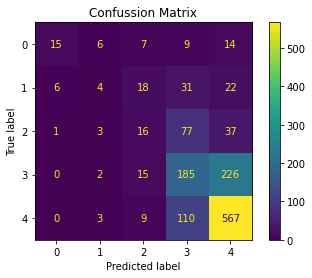

ValueError: multi_class must be in ('ovo', 'ovr')

In [91]:
show_metrics(xgb_model_new,smote_x_bow,x_test_bow,smote_y,y_test,X,y)